# Load Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time

from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Load Data

### Scraping Data from Basketball Reference

In [ ]:
def single_player(season):
    url = f'https://www.basketball-reference.com/leagues/NBA_{season}_totals.html'
    table_html = BeautifulSoup(urlopen(url), 'html.parser').findAll('table')
    df = pd.read_html(str(table_html))[0]
    df = df.drop('Rk', 1) # drop Rk columns
    df.Player = df.Player.str.replace('*','') # remove asterisk on player's name
    df.insert(0,'Season',season) # insert season column
    df = df.apply(pd.to_numeric, errors='coerce').fillna(df) 
    return df

def multiple_player(start_year,end_year):
    df = single_player(start_year)
    while start_year < end_year:
        time.sleep(4)                
        start_year = start_year + 1   
        df = df.append(single_player(start_year))
    return df

def scrape_NBA_team_data(years = [2017, 2018]):
    
    final_df = pd.DataFrame(columns = ["Year", "Team", "W", "L",
                                       "W/L%", "GB", "PS/G", "PA/G",
                                       "SRS", "Playoffs",
                                       "Losing_season"])
    
    # loop through each year
    for y in years:
        # NBA season to scrape
        year = y
        
        # URL to scrape, notice f string:
        url = f"https://www.basketball-reference.com/leagues/NBA_{year}_standings.html"
        
        # collect HTML data
        html = urlopen(url)
        
        # create beautiful soup object from HTML
        soup = BeautifulSoup(html, features="lxml")
        
        # use getText()to extract the headers into a list
        titles = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        
        # first, find only column headers
        headers = titles[1:titles.index("SRS")+1]
        
        # then, exclude first set of column headers (duplicated)
        titles = titles[titles.index("SRS")+1:]
        
        # next, row titles (ex: Boston Celtics, Toronto Raptors)
        try:
            row_titles = titles[0:titles.index("Eastern Conference")]
        except: row_titles = titles
        # remove the non-teams from this list
        for i in headers:
            row_titles.remove(i)
        row_titles.remove("Western Conference")
        divisions = ["Atlantic Division", "Central Division",
                     "Southeast Division", "Northwest Division",
                     "Pacific Division", "Southwest Division",
                     "Midwest Division"]
        for d in divisions:
            try:
                row_titles.remove(d)
            except:
                print("no division:", d)
        
        # next, grab all data from rows (avoid first row)
        rows = soup.findAll('tr')[1:]
        team_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        # remove empty elements
        team_stats = [e for e in team_stats if e != []]
        # only keep needed rows
        team_stats = team_stats[0:len(row_titles)]
        
        # add team name to each row in team_stats
        for i in range(0, len(team_stats)):
            team_stats[i].insert(0, row_titles[i])
            team_stats[i].insert(0, year)
            
        # add team, year columns to headers
        headers.insert(0, "Team")
        headers.insert(0, "Year")
        
        # create a dataframe with all aquired info
        year_standings = pd.DataFrame(team_stats, columns = headers)
        
        # add a column to dataframe to indicate playoff appearance
        year_standings["Playoffs"] = ["Y" if "*" in ele else "N" for ele in year_standings["Team"]]
        # remove * from team names
        year_standings["Team"] = [ele.replace('*', '') for ele in year_standings["Team"]]
        # add losing season indicator (win % < .5)
        year_standings["Losing_season"] = ["Y" if float(ele) < .5 else "N" for ele in year_standings["W/L%"]]
        
        # append new dataframe to final_df
        final_df = pd.concat([final_df,year_standings],axis=0)
    return final_df

def scrape_award_winners(start_year,end_year,award):
    url = f'https://www.basketball-reference.com/awards/{award}.html'
    table_html = str(BeautifulSoup(urlopen(url), 'html.parser').findAll('table')[0])
    df = pd.read_html(str(table_html))[0]
    df.columns = df.columns.droplevel(0)
    df = df[['Season','Player']]
    return df.loc[(df['Season'] >= str(start_year)) & (df['Season'] <= str(end_year))]

In [ ]:
player_df = multiple_player(1998,2022)
player_df.head()

In [ ]:
!pwd

In [ ]:
player_df.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/players.csv',index = False)

In [ ]:
team_df = scrape_NBA_team_data(np.arange(1998,2023))
team_df.head()

In [ ]:
team_df['Playoffs'] = [1 if row['Playoffs'] == 'Y' else 0 for idx,row in team_df.iterrows()]
team_df['Losing_season'] = [1 if row['Losing_season'] == 'Y' else 0 for idx,row in team_df.iterrows()]
team_df.head()

In [ ]:
team_df.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/teams.csv',index = False)

In [ ]:
mvp_df = scrape_award_winners(1997,2022,'mvp')
mvp_df

In [ ]:
mvp_df.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/mvp.csv',index = False)

In [ ]:
players = pd.read_csv('nba_player_stats_2.csv')
team = pd.read_csv('NBA_Team_Stats.csv')

In [ ]:
players.tail(5)

In [ ]:
team.head()

## Data Merge and Clean

In [31]:
players = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/players.csv')
teams = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/teams.csv')
mvp = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/mvp.csv')
dpoy = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/data/dpoy.csv')

In [ ]:
players.head()

In [ ]:
teams.head()

In [ ]:
mvp.head()

In [ ]:
dpoy.head()

In [ ]:
players = players[players['Player'] != 'Player']

In [ ]:
team_mapping = {'Miami Heat':'MIA',
                'New York Knicks':'NYK', 
                'New Jersey Nets':'NJN',
                'Washington Wizards':'WAS', 
                'Orlando Magic':'ORL',
                'Boston Celtics':'BOS',
                'Philadelphia 76ers':'PHI', 
                'Chicago Bulls':'CHI', 
                'Indiana Pacers':'IND',
                'Charlotte Hornets':'CHO', 
                'Atlanta Hawks':'ATL', 
                'Cleveland Cavaliers':'CLE',
                'Detroit Pistons':'DET', 
                'Milwaukee Bucks':'MIL', 
                'Toronto Raptors':'TOR',
                'Utah Jazz':'UTA',
                'San Antonio Spurs':'SAS',
                'Minnesota Timberwolves':'MIN',
                'Houston Rockets':'HOU', 
                'Dallas Mavericks':'DAL',
                'Vancouver Grizzlies':'VAN',
                'Denver Nuggets':'DEN',
                'Seattle SuperSonics':'SEA',
                'Los Angeles Lakers':'LAL',
                'Phoenix Suns':'PHO',
                'Portland Trail Blazers':'POR',
                'Sacramento Kings':'SAC',
                'Golden State Warriors':'GSW',
                'Los Angeles Clippers':'LAC',
                'Memphis Grizzlies':'MEM',
                'New Orleans Hornets':'NOH',
                'Charlotte Bobcats':'CHA',
                'New Orleans/Oklahoma City Hornets':'NOK',
                'Oklahoma City Thunder':'OKC',
                'Brooklyn Nets':'BRK',
                'New Orleans Pelicans':'NOP'}

In [ ]:
teams_list = []
for idx,row in teams.iterrows():
    if row['Team'] == 'Charlotte Hornets':
        if row['Year'] <= 2006:
            teams_list.append('CHH')
        else:
            teams_list.append(team_mapping[row['Team']])
    else:
        teams_list.append(team_mapping[row['Team']])
teams['Team'] = teams_list

In [ ]:
players_team = {}
for ply,group in players.groupby(['Player','Season']):
    if group.shape[0] > 1:
        tm = list(group.Tm)[-1]
        if 28 in group.index:
            print(group.Tm)
        players_team[list(group.index)[0]] = tm
        if tm == 'TOT':
            print(ply)

In [ ]:
teams_list = []
for idx,row in players.iterrows():
    if idx in players_team.keys():
        tm = players_team[idx]
        teams_list.append(tm)
    else:
        tm = row['Tm']
        if idx == 3613:
            tm = 'UTA'
        elif idx == 21:
            tm = 'MIA'
        elif idx == 4189:
            tm = 'WAS'
        elif idx == 3037:
            tm = 'BOS'
        elif idx == 11099:
            tm = 'CHI'
        elif idx == 6128:
            tm = 'NJN'
        teams_list.append(tm)

players['Tm'] = teams_list

In [ ]:
players.drop_duplicates(['Player','Season'],keep = 'first',inplace = True)

In [ ]:
players_team = players.merge(teams, left_on = ['Tm','Season'],right_on = ['Team','Year'],how = 'inner')
players_team.shape

In [ ]:
players_team.to_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/players_team.csv')

In [39]:
year_vec = []
for idx,row in mvp.iterrows():
    if row['Season'][-2] == '9':
        year_vec.append('19' + row['Season'].split('-')[1])
    else:
        year_vec.append('20' + row['Season'].split('-')[1])
mvp['Season'] = year_vec

In [40]:
year_vec = []
for idx,row in dpoy.iterrows():
    if row['Season'][-2] == '9':
        year_vec.append('19' + row['Season'].split('-')[1])
    else:
        year_vec.append('20' + row['Season'].split('-')[1])
dpoy['Season'] = year_vec

In [ ]:
### ADD DPY AND MVP TO THE DATAFRAME

In [36]:
df = pd.read_csv('/Users/claykindiger/Documents/Rice/2023 Fall/DSCI 303/DSCI303FinalProject/players_team.csv')

In [47]:
dpoy.tail()

,Season,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,-9999
21,2002,NBA,Ben Wallace,(V),27,DET,80,36.5,7.6,13.0,1.4,1.7,3.5,0.531,0.0,0.423,11.6,0.190,wallabe01
22,2001,NBA,Dikembe Mutombo,(V),34,TOT,75,34.5,10.0,13.5,1.0,0.4,2.7,0.484,NaN,0.725,8.1,0.151,mutomdi01
23,2000,NBA,Alonzo Mourning,(V),29,MIA,79,34.8,21.7,9.5,1.6,0.5,3.7,0.551,0.0,0.711,12.9,0.226,mournal01
24,1999,NBA,Alonzo Mourning,(V),28,MIA,46,38.1,20.1,11.0,1.6,0.7,3.9,0.511,0.0,0.652,7.9,0.216,mournal01
25,1998,NBA,Dikembe Mutombo,(V),31,ATL,82,35.6,13.4,11.4,1.0,0.4,3.4,0.537,NaN,0.670,10.8,0.177,mutomdi01


In [46]:
df.head()

,Unnamed: 0,Season,Player,Pos,Age,Tm,G,GS,MP,FG,...,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
0,0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,31.0,0.0,530.0,103.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
1,1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,59.0,16.0,959.0,144.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
2,2,1998,Terry Dehere,PG,26.0,SAC,77.0,18.0,1410.0,180.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
3,3,1998,Lawrence Funderburke,PF,27.0,SAC,52.0,1.0,1094.0,191.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
4,4,1998,Derek Grimm,SF,23.0,SAC,9.0,0.0,34.0,4.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0


In [48]:
df[df['Player'] == 'Dikembe Mutombo']

,Unnamed: 0,Season,Player,Pos,Age,Tm,G,GS,MP,FG,...,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
86,86,1998,Dikembe Mutombo,C,31.0,ATL,82.0,82.0,2917.0,399.0,...,32,0.610,12.0,95.9,92.3,3.85,1,0,0,0
739,739,1999,Dikembe Mutombo,C,32.0,ATL,50.0,50.0,1829.0,173.0,...,19,0.620,2.0,86.3,83.4,2.82,1,0,0,0
1100,1100,2000,Dikembe Mutombo,C,33.0,ATL,82.0,82.0,2984.0,322.0,...,54,0.341,28.0,94.3,99.7,-5.41,0,1,0,0
1536,1536,2001,Dikembe Mutombo,C,34.0,PHI,75.0,75.0,2591.0,269.0,...,26,0.683,—,94.7,90.4,3.64,1,0,0,0
2062,2062,2002,Dikembe Mutombo,C,35.0,PHI,80.0,80.0,2907.0,321.0,...,39,0.524,9.0,91.0,89.4,1.27,1,0,0,0
2394,2394,2003,Dikembe Mutombo,C,36.0,NJN,24.0,16.0,514.0,49.0,...,33,0.598,—,95.4,90.1,4.42,1,0,0,0
2715,2715,2004,Dikembe Mutombo,C,37.0,NYK,65.0,56.0,1494.0,141.0,...,43,0.476,8.0,92.0,93.5,-1.97,1,1,0,0
3308,3308,2005,Dikembe Mutombo,C,38.0,HOU,80.0,2.0,1212.0,108.0,...,31,0.622,8.0,95.1,91.0,4.27,1,0,0,0
3620,3620,2006,Dikembe Mutombo,C,39.0,HOU,64.0,23.0,955.0,50.0,...,48,0.415,29.0,90.1,91.7,-1.30,0,1,0,0
4105,4105,2007,Dikembe Mutombo,C,40.0,HOU,75.0,33.0,1289.0,85.0,...,30,0.634,15.0,97.0,92.1,5.04,1,0,0,0


In [51]:
dpoy.loc[(dpoy['Player'] == 'Dikembe Mutombo') & (dpoy['Season'] == '1998')]

,Season,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,-9999
25,1998,NBA,Dikembe Mutombo,(V),31,ATL,82,35.6,13.4,11.4,1.0,0.4,3.4,0.537,NaN,0.67,10.8,0.177,mutomdi01


In [52]:
mvp_vec = []
dpoy_vec = []
for idx,row in df.iterrows():
    if mvp.loc[(mvp['Player'] == row['Player']) & (mvp['Season'] == str(row['Season']))].shape[0] > 0:
        mvp_vec.append(1)
    else:
        mvp_vec.append(0)
        
    if dpoy.loc[(dpoy['Player'] == row['Player']) & (dpoy['Season'] == str(row['Season']))].shape[0] > 0:
        dpoy_vec.append(1)
    else:
        dpoy_vec.append(0)
        
df['mvp'] = mvp_vec
df['dpoy'] = dpoy_vec

df.mvp.value_counts()

0    11837
1       25
Name: mvp, dtype: int64

In [60]:
df.head()

,Unnamed: 0,Season,Player,Pos,Age,Tm,G,GS,MP,FG,...,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
0,0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,31.0,0.0,530.0,103.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
1,1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,59.0,16.0,959.0,144.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
2,2,1998,Terry Dehere,PG,26.0,SAC,77.0,18.0,1410.0,180.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
3,3,1998,Lawrence Funderburke,PF,27.0,SAC,52.0,1.0,1094.0,191.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
4,4,1998,Derek Grimm,SF,23.0,SAC,9.0,0.0,34.0,4.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0


In [61]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [62]:
df.to_csv('full_player_stats.csv',index = False)

## EDA

### Load Clean Data

In [63]:
players_team = pd.read_csv('full_player_stats.csv')
players_team.head()

,Season,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,31.0,0.0,530.0,103.0,273.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,59.0,16.0,959.0,144.0,357.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
2,1998,Terry Dehere,PG,26.0,SAC,77.0,18.0,1410.0,180.0,451.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
3,1998,Lawrence Funderburke,PF,27.0,SAC,52.0,1.0,1094.0,191.0,390.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0
4,1998,Derek Grimm,SF,23.0,SAC,9.0,0.0,34.0,4.0,14.0,...,55,0.329,34.0,93.1,98.7,-5.83,0,1,0,0


In [64]:
df_num = players_team.select_dtypes(include = 'number')
df_num.head()

,Season,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,W,L,W/L%,PS/G,PA/G,SRS,Playoffs,Losing_season,mvp,dpoy
0,1998,28.0,31.0,0.0,530.0,103.0,273.0,0.377,5.0,31.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
1,1998,23.0,59.0,16.0,959.0,144.0,357.0,0.403,4.0,19.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
2,1998,26.0,77.0,18.0,1410.0,180.0,451.0,0.399,50.0,132.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
3,1998,27.0,52.0,1.0,1094.0,191.0,390.0,0.490,1.0,7.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0
4,1998,23.0,9.0,0.0,34.0,4.0,14.0,0.286,4.0,12.0,...,27,55,0.329,93.1,98.7,-5.83,0,1,0,0


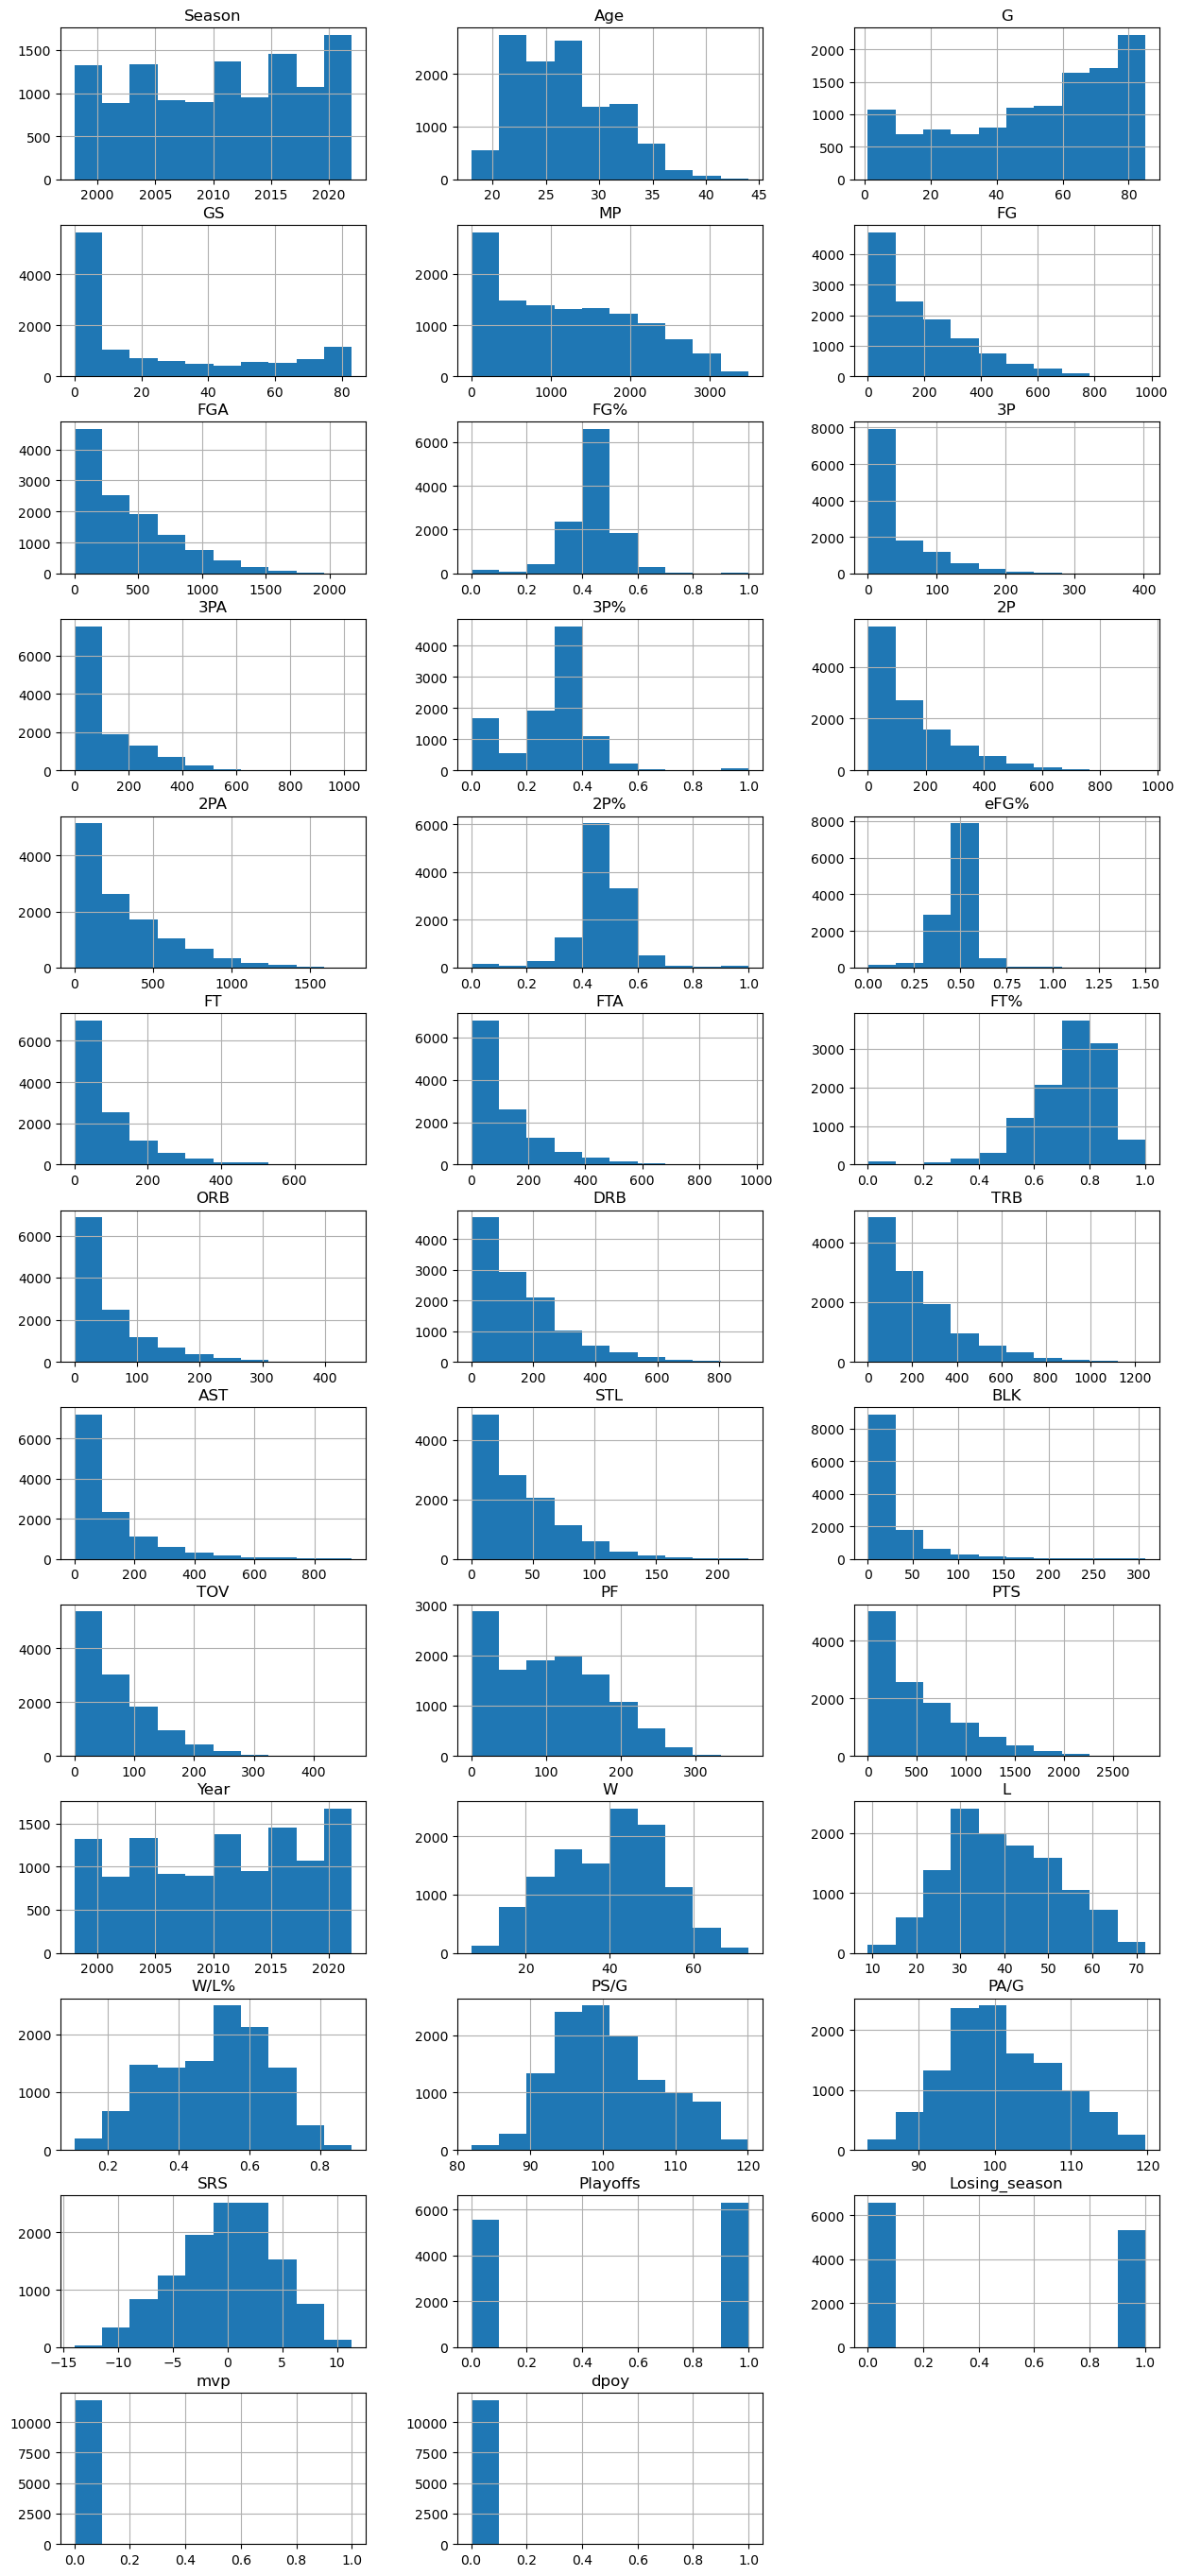

In [65]:
hist = df_num.hist(layout=(15,3),figsize=(15,40))